# Self-supervised scene classification
Note that a lot of this code has been based on the practical session of the course.

In [35]:
import torch
from torchvision import datasets, transforms, models
import torchvision
from torch.optim import Adam

from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

import os
import time

from PIL import Image

In [36]:
## input
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 15

## 2 15-Scene Dataset
The dataset contains 15 categories of different scenes [1]. The categories are office,
kitchen, living room, bedroom, store, industrial, tall building, inside cite, street, highway,
coast, open country, mountain, forest, and suburb. The dataset has been divided into
two parts train and test. Each part has equally 15 different classes of scenes. The train
set is used during the training process in order to ”teach” the model how to classify images. The validation set is used to evaluate the model after each epoch, it is not seen
by the model during training. You will find the dataset in the BlackBoard platform, located at UA 2500WETANN: Artificial Neural Material > Practical Session > datasets >
self-supervised scene classification Project.

In [37]:
def get_scene_data_loader(batch_size):
    """
    Returns a train and validation data loader for the 15 scene dataset.

    :param batch_size: the batch size to use

    :return: the train and validation data loader
    """

    # Transformations to be applied on the images
    transform = transforms.Compose([
        transforms.Resize(INPUT_SHAPE[:2]),
        transforms.ToTensor()
    ])


    # Load the dataset
    data_folder = '15SceneData_small'

    train_folder = os.path.join(data_folder, 'train')
    val_folder = os.path.join(data_folder, 'validation')

    train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_folder, transform=transform)

    # Create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # get the labels
    global LABELS
    LABELS = train_dataset.classes

    # for testing only if no 15SceneData_small folder
    # train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, sampler=torch.utils.data.SubsetRandomSampler(range(0, int(len(train_dataset) * 0.1))))
    # val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, sampler=torch.utils.data.SubsetRandomSampler(range(0, int(len(train_dataset) * 0.1))))


    return train_loader, val_loader

In [38]:
train_loader, val_loader = get_scene_data_loader(BATCH_SIZE)

In [49]:
def visualize_3x3_images(images, labels, class_names=None):
    """
    Visualizes a 3x3 plot of images with their corresponding labels.

    :param images: the images to plot
    :param labels: the labels to plot
    """
    if class_names is None:
        class_names = LABELS

    fig, axes = plt.subplots(nrows=3, ncols=3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(f"{class_names[labels[i]]}")
        ax.axis('off')

    plt.show()

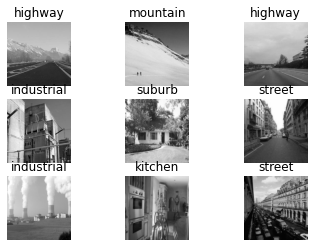

In [50]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))
visualize_3x3_images(images, labels)

## 3 Classification schemes
In this section, the fully-supervised and self-supervised methods that should be implemented in this assignment are explained in more detail.

In [22]:
class TrainLogger:
    def __init__(self, descr=""):
        self.train_loss_list_per_epoch = []
        self.train_loss_list_per_itr = []
        self.val_loss_list = []
        self.val_accuracy_per_epoch = []
        self.time_s = time.time()

        self.identifier = descr + "_" + str(self.time_s)

        self.time_e = None

    def notify_itr_end(self, itr, train_loss):
        if itr % 10 == 0:
            self.train_loss_list_per_itr.append(train_loss.item())

    def notify_epoch_end(self, epoch, eval_loss, eval_acc):
        self.train_loss_list_per_epoch.append(np.mean(self.train_loss_list_per_itr))
        self.train_loss_list_per_itr = []

        self.val_loss_list.append(eval_loss)
        self.val_accuracy_per_epoch.append(eval_acc)

    def get_train_duration(self):
        """Returns the duration of the training in minutes"""
        return (self.time_e - self.time_s) / 60

    def notify_train_end(self):
        self.time_e = time.time()
        print(f"Training time in Mins : {self.get_train_duration()}")

        print('Train loss values per iteration')
        print(self.train_loss_list_per_epoch)

        self.plot_all()

    def plot_all(self):
        plt.plot(np.arange(len(self.train_loss_list_per_epoch)), self.train_loss_list_per_epoch,color='blue',label='Train')
        plt.plot(np.arange(len(self.val_loss_list)), self.val_loss_list,color='red',label='Validation')
        plt.legend()
        plt.title('Train and Validation Loss')
        plt.savefig(f'{self.identifier}_train_val_loss.png')

        plt.cla()

        plt.plot(np.arange(len(self.val_accuracy_per_epoch)), self.val_accuracy_per_epoch,color='green',label='Validation')
        plt.title('Validation Accuracy')
        plt.savefig(f'{self.identifier}_validation_accuracy.png')

In [23]:
class TrainConfig:
    def __init__(self, lr=0.001, num_epochs=10, criterion=None, optimizer="Adam"):
        self.lr = lr
        self.num_epochs = num_epochs
        self.criterion = criterion if criterion else torch.nn.CrossEntropyLoss()
        self.optimizer = optimizer

    def get_optimizer(self, model):
        if self.optimizer == "Adam":
            return Adam(model.parameters(), lr=self.lr)
        else:
            raise NotImplementedError("Optimizer not implemented")

In [24]:
import numpy as np
from torch import nn, optim
from tqdm import tqdm

def evalution(model, validation_loader,criterion,pretext_task=None):

    val_loss = []

    real_label = None
    pred_label = None
    for inputs, labels in validation_loader:

        if pretext_task is not None
            inputs = pretext_task(inputs)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss.append(loss.item())

        _, preds = torch.max(outputs, 1)
        if real_label is None:
            real_label = labels.data
            pred_label = preds
        else:
            real_label = torch.cat((real_label, labels.data), dim=0)
            pred_label = torch.cat((pred_label, preds), dim=0)

        del inputs
        del labels

    real_label = real_label.detach().cpu().numpy()
    pred_label = pred_label.detach().cpu().numpy()

    eval_acc = accuracy_score(real_label, pred_label)
    # report = classification_report(real_label, pred_label)
    # eval_acc = float(report.split('accuracy')[1].split(' ')[27])

    return np.mean(val_loss), eval_acc

In [25]:
def train(model, train_loader, validation_loader, train_config, pretext_task=None, log_descr=None):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = train_config.get_optimizer(model)
    log = TrainLogger(log_descr)

    for epoch in range(train_config.num_epochs):
        for itr, (inputs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):

            if pretext_task is not None:
                # change the inputs and labels to the pretext task
                inputs, labels = pretext_task(inputs, labels)

            outputs = model(inputs)
            loss = criterion(outputs,labels)

            # clearing old gradients from the last step
            optimizer.zero_grad()
            # computing the derivative of the loss w.r.t. the parameters
            loss.backward()
            # optimizer takes a step in updating parameters based on the gradients of the parameters.
            optimizer.step()

            log.notify_itr_end(itr, train_loss=loss)

        # Evaluate model for each update iteration
        eval_loss, eval_acc = evalution(model, validation_loader, criterion, pretext_task)

        log.notify_epoch_end(epoch, eval_loss=eval_loss, eval_acc=eval_acc)

    log.notify_train_end()

    return model, log

In [ ]:
# load the model
def load_model(path, num_classes=NUM_CLASSES, evaluation_mode=True):
    model_efficient_b0 =  torchvision.models.efficientnet_b0(weights=True)

    classifier_in = model_efficient_b0.classifier[-1].in_features
    model_efficient_b0.classifier[-1] = torch.nn.Linear(in_features=classifier_in, out_features=num_classes)

    model_efficient_b0.load_state_dict(torch.load(path))

    if evaluation_mode:
        model_efficient_b0.eval()

    return model_efficient_b0

In [ ]:
def make_trainable(model, train_features: bool, train_classifier: bool):
    for params in model.features.parameters():
        params.requires_grad = train_features

    for params in model.classifier.parameters():
        params.requires_grad = train_classifier

In [ ]:
def modify_classification_head(model, num_classes):
    classifier_in = model.classifier[-1].in_features
    model.classifier[-1] = torch.nn.Linear(in_features=classifier_in, out_features=num_classes)
    return model

## 3.1 Supervised learning scheme
In this section, you should fine-tune a convolutional neural network architecture, pretrained on the ImageNet [2] dataset, on the 15 scene dataset. In this assignment you will
use a pre-trained EfficientNet-B0 architecture. Following the exercise session on Transfer
Learning, you should make all layers in feature extraction and classifier parts of the model
trainable. The bellow address provides you with the scheme of the architecture of the
EfficientNet-B0.
https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10/10 [00:20<00:00,  2.06s/it]
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and be

Training time in Mins : 2.0009924372037253
Train loss values per iteration
[2.7231814861297607, 1.0023788213729858, 0.34183284640312195]


ValueError: not enough values to unpack (expected 4, got 1)

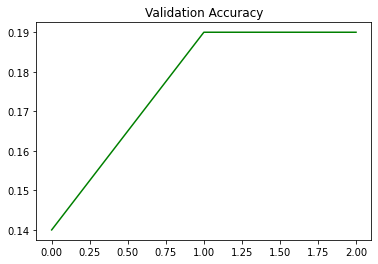

In [26]:
model_efficient_b0 =  torchvision.models.efficientnet_b0(weights=True)

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

# Number of classes is different, so change the last classification layer
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig(num_epochs=10, optimizer="Adam", lr=0.001)

model_efficient_b0,train_log = train(model_efficient_b0, train_loader, val_loader, train_config, log_descr="supervised")

torch.save(model_efficient_b0.state_dict(), 'model_efficient_b0_supervised.pth')

## 3.2 Self-supervised learning scheme

### 3.2.1 Pretext Task 1: Rotation Classification

In [53]:
class RotationPretext:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, inputs, labels):
        """"
        :param inputs: batch of images
        :param labels: batch of labels
        :return: rotated images and labels corresponding to the rotation angle
        """
        for i in range(len(inputs)):
            angle_index = np.random.randint(len(self.angles))
            angle = self.angles[angle_index]
            inputs[i] = transforms.functional.rotate(inputs[i], angle)
            labels[i] = angle_index
        return inputs, labels

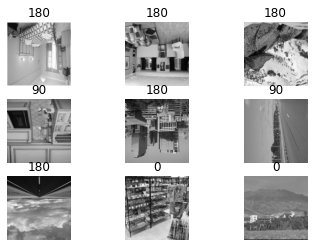

In [54]:
# test the rotation pretext task
images, labels = next(iter(train_loader))

angles = [0, 90, 180, 270]
rotation_pretext = RotationPretext([0, 90, 180, 270])
images, labels = rotation_pretext(images, labels)

visualize_3x3_images(images, labels, class_names=angles)

In [ ]:
model_efficient_b0 =  torchvision.models.efficientnet_b0(weights=True)


# Pretext Task
angles = [0, 90, 180, 270]
pretext_task = RotationPretext(angles=angles)
modify_classification_head(model_efficient_b0, num_classes=len(angles))

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig(num_epochs=10, optimizer="Adam", lr=0.001)

model_efficient_b0,pretext_log = train(model_efficient_b0, train_loader, val_loader, train_config, pretext_task=pretext_task, log_descr="pretext_only_rotation")


# Actual scene classification task
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(model_efficient_b0, train_features=False, train_classifier=True)

train_config = TrainConfig(num_epochs=10, optimizer="Adam", lr=0.001)

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config, log_descr="pretext_rotation")

### 3.2.2 Pretext Task 2: Perturbation Classification

In [59]:
class PerturbationPretext:
    def __init__(self, perbutation_colors=[0, 255]):
        self.perbutation_colors = perbutation_colors

    def __call__(self, inputs, labels):
        """"
        :param inputs: batch of images
        :param labels: batch of labels
        :return: perturbed images and labels corresponding the perbutation color
        """
        for i in range(len(inputs)):
            perturbation_index = np.random.randint(len(self.perbutation_colors))
            perturbation_color = self.perbutation_colors[perturbation_index]
            inputs[i] = self._apply_perbutation(inputs[i], perturbation_color)
            labels[i] = perturbation_index
        return inputs, labels

    def _apply_perbutation(self, input, color):
        """"
        To do the perturbation you need to define a random square region W with a shape 10 × 10 on an image. Then, the pixels within the window are set to given color
        """
        region_size = 10
        x = np.random.randint(0, input.shape[1] - region_size)
        y = np.random.randint(0, input.shape[2] - region_size)
        input[:, x:x + region_size, y:y + region_size] = color
        return input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


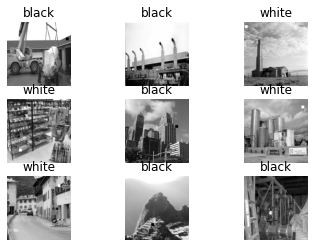

In [60]:
# test the perturbation pretext task
images, labels = next(iter(train_loader))

perturbation_pretext = PerturbationPretext()
images, labels = perturbation_pretext(images, labels)

visualize_3x3_images(images, labels, class_names=["black", "white"])

In [ ]:
model_efficient_b0 =  torchvision.models.efficientnet_b0(weights=True)


# Pretext Task
modify_classification_head(model_efficient_b0, num_classes=2)

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig(num_epochs=10, optimizer="Adam", lr=0.001)

pretext_task = PerturbationPretext()

model_efficient_b0, pretext_log = train(model_efficient_b0, train_loader, val_loader, train_config, pretext_task=pretext_task, log_descr="pretext_only_perturbation")


# Actual scene classification task
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(model_efficient_b0, train_features=False, train_classifier=True)

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config, log_descr="pretext_perturbation")

# Model explanation and interpretation
In this section, you are requested to explain and interpret the models trained following the
fully-supervised and self-supervised procedures.

In [ ]:
MODEL_SAVES = {
    "supervised": "",
    "pretext_rotation": "",
    "pretext_perturbation": ""
}


## Explanation

In [ ]:
from torchcam.methods import ScoreCAM

def explain_predictions(model, val_batch):
    """
    Takesimages from the validation set and generates a Score-CAM explanation for each of them.
    :param model: the model to be explained
    :param val_batch: the validation set images and labels to explain
    """

    explanations = []

    images = val_batch[0]
    labels = val_batch[1]

    for image, label in zip(images, labels):
        # get the explanation for the final layr
        target_layer = model._modules.get('classifier') # tODO: dit of model.classifier[-1]
        cam_extractor = ScoreCAM(model=model, target_layer=target_layer)

        # get the explanation for the image
        explanation = cam_extractor(image, target_category=label)
        explanations.append(explanation)

        # create plots, where each row contais the original image, the heatmap and the heatmap overlayed on the original image
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image.permute(1, 2, 0))
        ax[0].set_title("Original image")

        ax[1].imshow(explanation.squeeze().permute(1, 2, 0))
        ax[1].set_title("Heatmap")

        ax[2].imshow(image.permute(1, 2, 0))
        ax[2].imshow(explanation.squeeze().permute(1, 2, 0), alpha=0.5)
        ax[2].set_title("Heatmap overlayed on the original image")

images_to_explain = next(iter(val_loader))[0][:3]

In [ ]:
model = load_model(MODEL_SAVES["supervised"])
explain_predictions(model, images_to_explain)

In [ ]:
model = load_model(MODEL_SAVES["pretext_rotation"])
explain_predictions(model, images_to_explain)

In [ ]:
model = load_model(MODEL_SAVES["pretext_perturbation"])
explain_predictions(model, images_to_explain)


## Interpretation
For the interpretation part, you should utilize the model inversion method proposed
in [3]. This model inversion technique is part of the last exercise session.

In [ ]:
from RegularizedUnitSpecificImageGeneration import RegularizedClassSpecificImageGeneration

def get_interpretation(model):
    target_class = "highway"
    target_class_idx = LABELS.index(target_class)

    csig = RegularizedClassSpecificImageGeneration(model, target_class_idx)
    csig.generate()

In [ ]:
model = load_model(MODEL_SAVES["supervised"])
get_interpretation(model)

In [ ]:
model = load_model(MODEL_SAVES["pretext_rotation"])
get_interpretation(model)

In [ ]:
model = load_model(MODEL_SAVES["pretext_perturbation"])
get_interpretation(model)